<a href="https://colab.research.google.com/github/Juliadambros/Sistema-de-Recomendacao-de-Filmes/blob/main/Recomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação com SVD, SVD Otimizado
Este notebook implementa um sistema de recomendação baseado em **filtragem colaborativa**, utilizando o algoritmo **SVD** e **NFM** da biblioteca `Surprise`

## Importação das Bibliotecas

In [2]:
!pip install numpy==1.24.4
!pip uninstall -y scikit-surprise
!pip install scikit-surprise

from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae, mse
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from surprise.model_selection import GridSearchCV



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463297 sha256=afcb5355e390750f166d24c11bdd74ac03f18c02de0c3f67b34c4db88425387a
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


##  Carregar o Dataset
O dataset deve conter pelo menos as colunas `userId`, `movieId` e `rating`.

In [3]:
url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
df = pd.read_csv(url, sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
df.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Carregando os dados dos filmes (para mostrar os nomes depois)

In [4]:
movie_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movie_columns = ['itemId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)]
movies_df = pd.read_csv(movie_url, sep='|', names=movie_columns, encoding='latin-1')

# Criando o dicionário de ID -> título do filme
movie_titles = dict(zip(movies_df['itemId'], movies_df['title']))

## Preparação dos Dados
Define o intervalo de notas e carrega os dados no formato da biblioteca `Surprise`.

In [5]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)

## Divisão dos Dados
Dividimos em 80% para treino e 20% para teste.

In [6]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=100)

### SVD padrão

## Treinamento do Modelo
Utilizamos o algoritmo **SVD**, que identifica padrões latentes nas avaliações.

In [7]:
model = SVD()
model.fit(trainset)

## Calcular R²

## Avaliação do Modelo
Utilizamos RMSE e MAE como métricas de erro.

In [8]:
predictions = model.test(testset)
print("Avaliação do Modelo SVD Padrão:")
svd_default_rmse = rmse(predictions)
svd_default_mse = mse(predictions)

Avaliação do Modelo SVD Padrão:
RMSE: 0.9338
MSE: 0.8721


## Geração de Recomendações
Selecionamos um usuário e recomendamos filmes que ele ainda não avaliou, com base nas maiores notas previstas.

In [9]:
user_id = 78
user_movies = df[df['userId'] == user_id]['itemId'].unique()
all_movie_ids = df['itemId'].unique()
movies_not_seen = [movie for movie in all_movie_ids if movie not in user_movies]

user_predictions = [model.predict(user_id, movie_id) for movie_id in movies_not_seen]
top_10 = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:10]

## Exibir Títulos dos Filmes

In [10]:
print(f"\nTop 10 recomendações para o usuário {user_id}:\n")
for pred in top_10:
    movie_name = movie_titles.get(int(pred.iid), f"ID {pred.iid}")
    print(f"{movie_name} — Nota prevista: {pred.est:.2f}")



Top 10 recomendações para o usuário 78:

Close Shave, A (1995) — Nota prevista: 4.85
Godfather, The (1972) — Nota prevista: 4.74
Silence of the Lambs, The (1991) — Nota prevista: 4.61
Shall We Dance? (1996) — Nota prevista: 4.61
Shawshank Redemption, The (1994) — Nota prevista: 4.61
Godfather: Part II, The (1974) — Nota prevista: 4.61
L.A. Confidential (1997) — Nota prevista: 4.60
12 Angry Men (1957) — Nota prevista: 4.57
Man Who Would Be King, The (1975) — Nota prevista: 4.57
Casablanca (1942) — Nota prevista: 4.57


### Otimização com GridSearchCV no SVD

In [11]:

param_grid = {
    'n_epochs': [30, 100, 500],
    'lr_all': [0.005, 0.01, 0.05],
    'reg_all': [0.2, 0.3, 0.4]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mse'], cv=3, n_jobs=-1)
gs.fit(data)

print("\nMelhor RMSE encontrado:", gs.best_score['rmse'])
print("Melhores parâmetros para o SVD:", gs.best_params['rmse'])


Melhor RMSE encontrado: 0.9296226797031434
Melhores parâmetros para o SVD: {'n_epochs': 500, 'lr_all': 0.005, 'reg_all': 0.2}


# Treinamento do Modelo SVD com melhores hiperparâmetros

In [12]:
best_svd = SVD(**gs.best_params['rmse'])
best_svd.fit(trainset)

# Avaliação do SVD otimizado

In [13]:
best_predictions = best_svd.test(testset)

print("\nAvaliação do Melhor Modelo SVD (GridSearch):")
svd_grid_rmse = rmse(best_predictions)
svd_grid_mse = mse(best_predictions)


Avaliação do Melhor Modelo SVD (GridSearch):
RMSE: 0.9255
MSE: 0.8566


## Utilização do NFM (Fatoração de matriz não linear )

In [14]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)

print("\nAvaliação do Modelo NMF:")
nmf_rmse = rmse(nmf_predictions)
nmf_mse = mse(nmf_predictions)


Avaliação do Modelo NMF:
RMSE: 0.9579
MSE: 0.9176


In [15]:
user_predictions_nmf = [nmf_model.predict(user_id, movie_id) for movie_id in movies_not_seen]
top_10_nmf = sorted(user_predictions_nmf, key=lambda x: x.est, reverse=True)[:10]

print(f"\nTop 10 recomendações para o usuário {user_id} com NMF:\n")
for pred in top_10_nmf:
    movie_name = movie_titles.get(int(pred.iid), f"ID {pred.iid}")
    print(f"{movie_name} — Nota prevista: {pred.est:.2f}")



Top 10 recomendações para o usuário 78 com NMF:

Three Colors: Blue (1993) — Nota prevista: 5.00
Big Blue, The (Grand bleu, Le) (1988) — Nota prevista: 5.00
Maya Lin: A Strong Clear Vision (1994) — Nota prevista: 5.00
Underground (1995) — Nota prevista: 5.00
Hugo Pool (1997) — Nota prevista: 5.00
Pather Panchali (1955) — Nota prevista: 5.00
Celestial Clockwork (1994) — Nota prevista: 5.00
World of Apu, The (Apur Sansar) (1959) — Nota prevista: 5.00
Magic Hour, The (1998) — Nota prevista: 5.00
Nénette et Boni (1996) — Nota prevista: 4.96


In [16]:
param_grid_nmf = {
    'n_factors': [20, 30, 50],
    'n_epochs': [30, 100, 500],
    'reg_pu': [0.06, 0.1, 0.15],
    'reg_qi': [0.06, 0.1, 0.15]
}

gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mse'], cv=3, n_jobs=-1)
gs_nmf.fit(data)

print("\nMelhor RMSE encontrado para NMF:", gs_nmf.best_score['rmse'])
print("Melhores parâmetros para o NMF:", gs_nmf.best_params['rmse'])

best_nmf = NMF(**gs_nmf.best_params['rmse'])
best_nmf.fit(trainset)
best_nmf_predictions = best_nmf.test(testset)

nmf_grid_rmse = rmse(best_nmf_predictions)
nmf_grid_mse = mse(best_nmf_predictions)


Melhor RMSE encontrado para NMF: 0.9262186765941672
Melhores parâmetros para o NMF: {'n_factors': 50, 'n_epochs': 500, 'reg_pu': 0.15, 'reg_qi': 0.1}
RMSE: 0.9122
MSE: 0.8321


### Comparação dos modelos em Gráfico

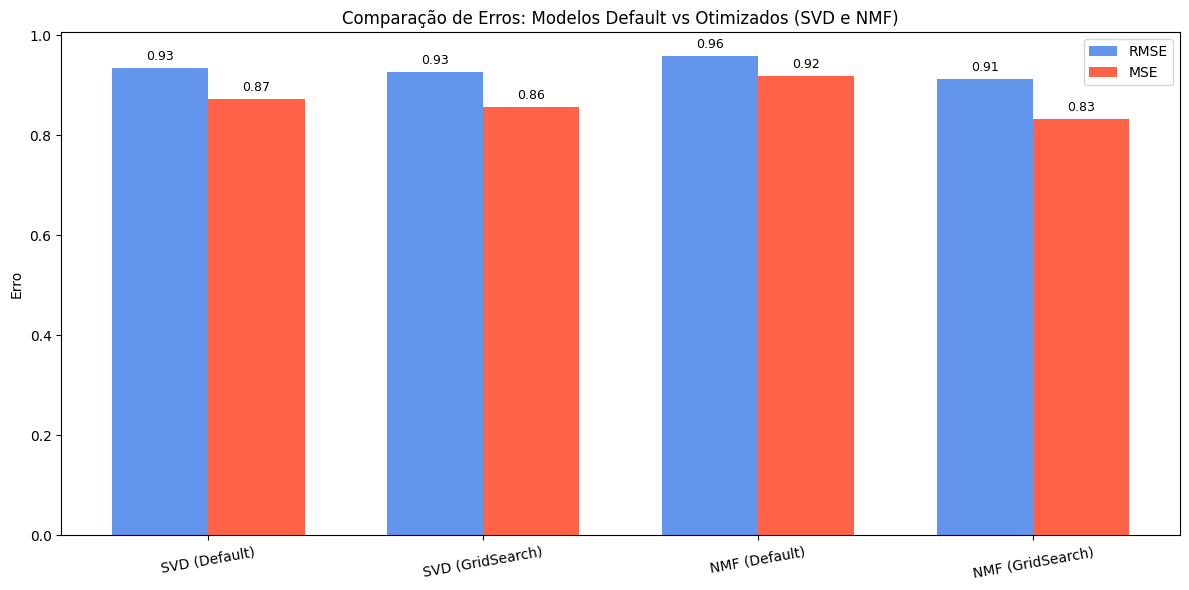

In [17]:
models = ['SVD (Default)', 'SVD (GridSearch)', 'NMF (Default)', 'NMF (GridSearch)']
rmse_values = [svd_default_rmse, svd_grid_rmse, nmf_rmse, nmf_grid_rmse]
mse_values = [svd_default_mse, svd_grid_mse, nmf_mse, nmf_grid_mse]


x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='cornflowerblue')
rects2 = ax.bar(x + width/2, mse_values, width, label='MSE', color='tomato')

ax.set_ylabel('Erro')
ax.set_title('Comparação de Erros: Modelos Default vs Otimizados (SVD e NMF)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=10)
ax.legend()

# Mostrar valores nas colunas
for i, rect in enumerate(rects1):
    ax.text(rect.get_x() + rect.get_width()/2., rect.get_height() + 0.01,
            f'{rmse_values[i]:.2f}', ha='center', va='bottom', fontsize=9)

for i, rect in enumerate(rects2):
    ax.text(rect.get_x() + rect.get_width()/2., rect.get_height() + 0.01,
            f'{mse_values[i]:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
